<a href="https://colab.research.google.com/github/cinumell/stock_price_prediction_Deep_Learning/blob/main/Companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction on the different companies' stock price 



1.   Amazon - AMZN
2.   Apple - AAPL
3.   Microsoft - MSFT
4. Google - GOOGL
5. Tesla - TSLA
6. Oracle - ORCL


We are downloading datasets from https://www.tiingo.com/. We will evaluate datasets from various firms. We used Google and Microsoft databases for our baseline calculations.

With a ratio of 80:20, we want to divide the Tiingo dataset into training and validation datasets. The exact training data and validation (test) data values may be different depending on the company symbol. To train the three different models, we will need the dataset's opening price, closing price,high price,and low price labels (prediction labels/classes). 

As the training dataset, we will first extract 80% of the opening price, closing price,high price, and low price labels from the Tiingo dataset. The remaining 20% of the opening price, closing price,high price, and low price labels from the primary dataset will be extracted as the validation (test) dataset.

In [4]:
# Dataset download
import pandas_datareader as pr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Converting data to timeseries input

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)



def run_on_lstm_company_stock_price(company_tingo, company_name):
    step = 70 # time step
    company = company_tingo
    price_type = 'close'
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14,8))

    data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")
    data.to_csv(company+'.csv')

    data = pd.read_csv(company+'.csv')
    print(data.shape[0])
    
    #Baseline calculation

    Base_errors = []

    for types in ['open','close','high','low']:
        Price = data[types]
        Means = list()

        for i in range(len(Price) - step):
            Means.append(sum(Price[i:i+step])/step)  

        Error = math.sqrt(mean_squared_error(Price[step:],Means))
        Base_errors.append(Error)   
        print("Base case error for",types,"=",Error)    
    #plt.plot(Price)
    
    Price = data[price_type]

    # MinMax Scalimg
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    mms = MinMaxScaler(feature_range=(0,1))
    Price = mms.fit_transform(np.array(Price).reshape(-1,1))

    # Dataset split into train and test sets

    train_size = int(len(Price)*0.80)
    test_size = len(Price)-train_size
    train_data,test_data = Price[0:train_size,:],Price[train_size:len(Price),:1]
    
    time_step = step
    trainX, trainY = create_dataset(train_data, time_step)
    testX, testY = create_dataset(test_data, time_step)

    print(trainX.shape), print(trainY.shape)
    print(testX.shape), print(testY.shape)

    trainX = trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
    testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

    # Stacked LSTM model

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dense

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (step, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    model.fit(trainX,trainY,validation_data=(testX,testY),epochs=100,batch_size=64,verbose=1)

    # Prediction and error calculation

    train_predict = model.predict(trainX)
    test_predict = model.predict(testX)

    print(test_predict.shape)
    testY = testY.reshape(test_size-step-1,1)
    trainY = trainY.reshape(train_size-step-1,1)

    testY = mms.inverse_transform(testY)
    trainY = mms.inverse_transform(trainY)

    print(testY[0])
    print(trainY[0])

    train_predict = mms.inverse_transform(train_predict)
    test_predict = mms.inverse_transform(test_predict)

    print(train_predict[0])
    print(test_predict[0])

    print("Train data error =",math.sqrt(mean_squared_error(trainY,train_predict)))
    print("Test data error =",math.sqrt(mean_squared_error(testY,test_predict)))

    plt.style.use("seaborn-darkgrid")
    fig,ax = plt.subplots(figsize=(14,8))
    #Customize
    ax.set(title=f'{company_name.capitalize()}', 
       xlabel='Time Step (k)',
       ylabel='Price ($)')
    ax.plot(test_predict,label = "predicted")
    ax.plot(testY,label = "actual")
    ax.legend()
    return

## Performance evaluation for 6 companies

We used our companies dataset on LTSM model and checked for the mean squared error of each company for LTSM model. 
The six companies that we ran the model for are Amazon, Apple, Microsoft, Google, Tesla, Oracle. 

The actual and predicted accuracy for all these companies is comparable and the model works with good accuracy.

/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_19371/2895094338.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


1259
Base case error for open = 418.3137047698232
Base case error for close = 417.1335019045632
Base case error for high = 423.40778487298275
Base case error for low = 411.1558743945137
(936, 70)
(936,)
(181, 70)
(181,)
Metal device set to: Apple M1 Pro


2022-12-02 19:23:09.733498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 19:23:09.733905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-12-02 19:23:10.256990: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 19:23:11.425345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:23:11.583739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:23:11.746415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:23:11.927674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:23:12.215528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0774

2022-12-02 19:23:13.776666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:23:13.825813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:23:13.924011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 129ms/step - loss: 0.0774 - val_loss: 0.0209
Epoch 2/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0054 - val_loss: 0.0206
Epoch 3/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0031 - val_loss: 0.0196
Epoch 4/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0016 - val_loss: 0.0163
Epoch 5/100
15/15 [==============================] - 1s 42ms/step - loss: 8.9611e-04 - val_loss: 0.0132
Epoch 6/100
15/15 [==============================] - 1s 41ms/step - loss: 7.2428e-04 - val_loss: 0.0125
Epoch 7/100
15/15 [==============================] - 1s 41ms/step - loss: 7.0574e-04 - val_loss: 0.0124
Epoch 8/100
15/15 [==============================] - 1s 42ms/step - loss: 7.1610e-04 - val_loss: 0.0120
Epoch 9/100
15/15 [==============================] - 1s 41ms/step - loss: 7.0953e-04 - val_loss: 0.0125
Epoch 10/100
15/15 [==============================] - 1s 42ms/step - loss: 7.3418e-04 - val

15/15 [==============================] - 1s 42ms/step - loss: 4.9295e-04 - val_loss: 0.0073
Epoch 80/100
15/15 [==============================] - 1s 46ms/step - loss: 4.0182e-04 - val_loss: 0.0069
Epoch 81/100
15/15 [==============================] - 1s 43ms/step - loss: 3.7494e-04 - val_loss: 0.0070
Epoch 82/100
15/15 [==============================] - 1s 44ms/step - loss: 3.8741e-04 - val_loss: 0.0068
Epoch 83/100
15/15 [==============================] - 1s 44ms/step - loss: 3.7404e-04 - val_loss: 0.0067
Epoch 84/100
15/15 [==============================] - 1s 43ms/step - loss: 4.3963e-04 - val_loss: 0.0068
Epoch 85/100
15/15 [==============================] - 1s 44ms/step - loss: 5.1617e-04 - val_loss: 0.0067
Epoch 86/100
15/15 [==============================] - 1s 42ms/step - loss: 4.2120e-04 - val_loss: 0.0070
Epoch 87/100
15/15 [==============================] - 1s 44ms/step - loss: 3.8898e-04 - val_loss: 0.0065
Epoch 88/100
15/15 [==============================] - 1s 44ms/step -

2022-12-02 19:24:16.876647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:16.927782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:17.038256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 51ms/step
(181, 1)
[3062.08]
[1571.68]
[1588.2008]
[2899.5918]
Train data error = 66.4306295350851
Test data error = 288.6439229687478


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_19371/2895094338.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


1259
Base case error for open = 48.67341901416808
Base case error for close = 48.8438037057134
Base case error for high = 49.10025861535476
Base case error for low = 48.285244474171336
(936, 70)
(936,)
(181, 70)
(181,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 70, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
___________________________

2022-12-02 19:24:20.918748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:21.058619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:21.172540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:21.331605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:21.558177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0223

2022-12-02 19:24:23.174225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:23.225979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:24:23.331931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 135ms/step - loss: 0.0223 - val_loss: 3.3538e-04
Epoch 2/100
15/15 [==============================] - 1s 53ms/step - loss: 0.0058 - val_loss: 6.4875e-04
Epoch 3/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0052 - val_loss: 2.7712e-04
Epoch 4/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0044 - val_loss: 3.2417e-04
Epoch 5/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0043 - val_loss: 2.4248e-04
Epoch 6/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0038 - val_loss: 2.4188e-04
Epoch 7/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0031 - val_loss: 2.4516e-04
Epoch 8/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0029 - val_loss: 2.7258e-04
Epoch 9/100
15/15 [==============================] - 1s 44ms/step - loss: 0.0031 - val_loss: 2.9137e-04
Epoch 10/100
15/15 [==============================] - 1s 42ms/step - loss: 

Epoch 79/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0012 - val_loss: 3.5392e-04
Epoch 80/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0010 - val_loss: 1.3343e-04
Epoch 81/100
15/15 [==============================] - 1s 44ms/step - loss: 9.6116e-04 - val_loss: 1.6103e-04
Epoch 82/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0010 - val_loss: 1.5389e-04
Epoch 83/100
15/15 [==============================] - 1s 44ms/step - loss: 8.3767e-04 - val_loss: 1.4398e-04
Epoch 84/100
15/15 [==============================] - 1s 43ms/step - loss: 9.0497e-04 - val_loss: 1.2795e-04
Epoch 85/100
15/15 [==============================] - 1s 44ms/step - loss: 9.5678e-04 - val_loss: 2.3578e-04
Epoch 86/100
15/15 [==============================] - 1s 43ms/step - loss: 0.0011 - val_loss: 1.2012e-04
Epoch 87/100
15/15 [==============================] - 1s 44ms/step - loss: 0.0014 - val_loss: 6.4248e-04
Epoch 88/100
15/15 [===================

2022-12-02 19:25:29.440598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:29.489263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:29.606025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 55ms/step
(181, 1)
[159.59]
[178.02]
[183.48969]
[158.06912]
Train data error = 11.853825609089848
Test data error = 5.891558223634202


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_19371/2895094338.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


1259
Base case error for open = 14.993832314785877
Base case error for close = 15.010264886263462
Base case error for high = 14.764620008780676
Base case error for low = 15.064513278184743
(936, 70)
(936,)
(181, 70)
(181,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 70, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 25)                1625      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_______________________

2022-12-02 19:25:33.463625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:33.606091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:33.724334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:33.885522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:34.124650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0349

2022-12-02 19:25:35.947370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:36.000115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:25:36.113772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 148ms/step - loss: 0.0349 - val_loss: 0.0093
Epoch 2/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 3/100
15/15 [==============================] - 1s 48ms/step - loss: 9.5312e-04 - val_loss: 0.0020
Epoch 4/100
15/15 [==============================] - 1s 51ms/step - loss: 6.7318e-04 - val_loss: 0.0019
Epoch 5/100
15/15 [==============================] - 1s 52ms/step - loss: 5.6535e-04 - val_loss: 0.0022
Epoch 6/100
15/15 [==============================] - 1s 49ms/step - loss: 5.2529e-04 - val_loss: 0.0022
Epoch 7/100
15/15 [==============================] - 1s 47ms/step - loss: 5.2090e-04 - val_loss: 0.0025
Epoch 8/100
15/15 [==============================] - 1s 46ms/step - loss: 5.2561e-04 - val_loss: 0.0021
Epoch 9/100
15/15 [==============================] - 1s 45ms/step - loss: 5.0379e-04 - val_loss: 0.0019
Epoch 10/100
15/15 [==============================] - 1s 47ms/step - loss: 5.2692e-

15/15 [==============================] - 1s 45ms/step - loss: 2.6523e-04 - val_loss: 0.0014
Epoch 80/100
15/15 [==============================] - 1s 47ms/step - loss: 2.6029e-04 - val_loss: 0.0012
Epoch 81/100
15/15 [==============================] - 1s 48ms/step - loss: 2.5720e-04 - val_loss: 0.0010
Epoch 82/100
15/15 [==============================] - 1s 48ms/step - loss: 2.9341e-04 - val_loss: 0.0012
Epoch 83/100
15/15 [==============================] - 1s 46ms/step - loss: 2.5815e-04 - val_loss: 0.0011
Epoch 84/100
15/15 [==============================] - 1s 48ms/step - loss: 2.6196e-04 - val_loss: 0.0010
Epoch 85/100
15/15 [==============================] - 1s 50ms/step - loss: 2.4570e-04 - val_loss: 0.0011
Epoch 86/100
15/15 [==============================] - 1s 47ms/step - loss: 2.4576e-04 - val_loss: 0.0013
Epoch 87/100
15/15 [==============================] - 1s 48ms/step - loss: 2.5306e-04 - val_loss: 0.0012
Epoch 88/100
15/15 [==============================] - 1s 51ms/step -

2022-12-02 19:26:48.475821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:48.540102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:48.658600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 53ms/step
(181, 1)
[294.39]
[94.6]
[95.10435]
[278.75]
Train data error = 4.281968107750861
Test data error = 7.8170209241594675


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_19371/2895094338.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


1259
Base case error for open = 334.98782143469714
Base case error for close = 335.22546153067196
Base case error for high = 339.046761914231
Base case error for low = 331.163307011415
(936, 70)
(936,)
(181, 70)
(181,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 70, 128)           66560     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 25)                1625      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
___________________________

2022-12-02 19:26:52.214491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:52.370375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:52.497935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:52.672838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:52.933564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0322

2022-12-02 19:26:55.040534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:55.110654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:26:55.228704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 176ms/step - loss: 0.0322 - val_loss: 0.0266
Epoch 2/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0037 - val_loss: 0.0210
Epoch 3/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0012 - val_loss: 0.0191
Epoch 4/100
15/15 [==============================] - 1s 49ms/step - loss: 4.5228e-04 - val_loss: 0.0188
Epoch 5/100
15/15 [==============================] - 1s 48ms/step - loss: 3.9922e-04 - val_loss: 0.0176
Epoch 6/100
15/15 [==============================] - 1s 49ms/step - loss: 3.6129e-04 - val_loss: 0.0174
Epoch 7/100
15/15 [==============================] - 1s 48ms/step - loss: 3.5432e-04 - val_loss: 0.0175
Epoch 8/100
15/15 [==============================] - 1s 47ms/step - loss: 3.5234e-04 - val_loss: 0.0171
Epoch 9/100
15/15 [==============================] - 1s 47ms/step - loss: 3.5750e-04 - val_loss: 0.0173
Epoch 10/100
15/15 [==============================] - 1s 50ms/step - loss: 3.4947e-04 -

15/15 [==============================] - 1s 48ms/step - loss: 2.3449e-04 - val_loss: 0.0088
Epoch 80/100
15/15 [==============================] - 1s 46ms/step - loss: 2.2376e-04 - val_loss: 0.0088
Epoch 81/100
15/15 [==============================] - 1s 46ms/step - loss: 2.5058e-04 - val_loss: 0.0088
Epoch 82/100
15/15 [==============================] - 1s 46ms/step - loss: 2.0069e-04 - val_loss: 0.0092
Epoch 83/100
15/15 [==============================] - 1s 46ms/step - loss: 2.7495e-04 - val_loss: 0.0087
Epoch 84/100
15/15 [==============================] - 1s 46ms/step - loss: 2.1256e-04 - val_loss: 0.0086
Epoch 85/100
15/15 [==============================] - 1s 46ms/step - loss: 2.3275e-04 - val_loss: 0.0085
Epoch 86/100
15/15 [==============================] - 1s 46ms/step - loss: 2.3734e-04 - val_loss: 0.0087
Epoch 87/100
15/15 [==============================] - 1s 46ms/step - loss: 2.0759e-04 - val_loss: 0.0085
Epoch 88/100
15/15 [==============================] - 1s 46ms/step -

2022-12-02 19:28:06.575046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:06.633703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:06.769821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 52ms/step
(181, 1)
[2665.61]
[1134.42]
[1143.0352]
[2577.4417]
Train data error = 40.40506509024437
Test data error = 256.26592989057923


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_19371/2895094338.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


1259
Base case error for open = 231.04325901214918
Base case error for close = 231.8820674387342
Base case error for high = 238.32834308119035
Base case error for low = 224.06318452797603
(936, 70)
(936,)
(181, 70)
(181,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 70, 128)           66560     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 25)                1625      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
________________________

2022-12-02 19:28:10.533962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:10.684054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:10.815061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:10.987418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:11.228484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0178

2022-12-02 19:28:12.932183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:12.984038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:28:13.101051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 144ms/step - loss: 0.0178 - val_loss: 0.0050
Epoch 2/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 3/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 4/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 5/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 6/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 7/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 9/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 11/1

15/15 [==============================] - 1s 45ms/step - loss: 8.6617e-04 - val_loss: 0.0012
Epoch 81/100
15/15 [==============================] - 1s 45ms/step - loss: 8.2344e-04 - val_loss: 0.0011
Epoch 82/100
15/15 [==============================] - 1s 45ms/step - loss: 8.5932e-04 - val_loss: 9.2003e-04
Epoch 83/100
15/15 [==============================] - 1s 46ms/step - loss: 8.9751e-04 - val_loss: 0.0010
Epoch 84/100
15/15 [==============================] - 1s 46ms/step - loss: 9.2495e-04 - val_loss: 0.0011
Epoch 85/100
15/15 [==============================] - 1s 45ms/step - loss: 9.9560e-04 - val_loss: 9.7294e-04
Epoch 86/100
15/15 [==============================] - 1s 45ms/step - loss: 8.5664e-04 - val_loss: 8.7337e-04
Epoch 87/100
15/15 [==============================] - 1s 46ms/step - loss: 8.3140e-04 - val_loss: 8.6384e-04
Epoch 88/100
15/15 [==============================] - 1s 47ms/step - loss: 9.2762e-04 - val_loss: 8.7970e-04
Epoch 89/100
15/15 [============================

2022-12-02 19:29:21.360092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:21.409248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:21.542176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 54ms/step
(181, 1)
[840.23]
[321.35]
[312.33493]
[797.579]
Train data error = 55.784292387373725
Test data error = 62.13968495743046


/var/folders/p6/vpj9j15x7774phthzn6s023m0000gn/T/ipykernel_19371/2895094338.py:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data = pr.get_data_tiingo(company, api_key="0f6351ae343427e511f4d085681db7e303ffb969")


1259
Base case error for open = 4.550830772989606
Base case error for close = 4.531032878396391
Base case error for high = 4.498310658258072
Base case error for low = 4.570374371139862
(936, 70)
(936,)
(181, 70)
(181,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 70, 128)           66560     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 25)                1625      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
___________________________

2022-12-02 19:29:25.339735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:25.497240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:25.626721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:25.802034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:26.069408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.0247

2022-12-02 19:29:27.775320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:27.833839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:29:27.949899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 5s 145ms/step - loss: 0.0247 - val_loss: 0.0076
Epoch 2/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 3/100
15/15 [==============================] - 1s 59ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 5/100
15/15 [==============================] - 1s 49ms/step - loss: 9.4374e-04 - val_loss: 0.0027
Epoch 6/100
15/15 [==============================] - 1s 52ms/step - loss: 9.2727e-04 - val_loss: 0.0027
Epoch 7/100
15/15 [==============================] - 1s 48ms/step - loss: 8.8486e-04 - val_loss: 0.0026
Epoch 8/100
15/15 [==============================] - 1s 47ms/step - loss: 8.6009e-04 - val_loss: 0.0026
Epoch 9/100
15/15 [==============================] - 1s 46ms/step - loss: 8.4065e-04 - val_loss: 0.0027
Epoch 10/100
15/15 [==============================] - 1s 50ms/step - loss: 8.3816e-04 - val

15/15 [==============================] - 1s 45ms/step - loss: 3.0482e-04 - val_loss: 7.8936e-04
Epoch 79/100
15/15 [==============================] - 1s 45ms/step - loss: 2.9922e-04 - val_loss: 9.5606e-04
Epoch 80/100
15/15 [==============================] - 1s 46ms/step - loss: 3.3126e-04 - val_loss: 7.6388e-04
Epoch 81/100
15/15 [==============================] - 1s 46ms/step - loss: 3.1483e-04 - val_loss: 8.2573e-04
Epoch 82/100
15/15 [==============================] - 1s 45ms/step - loss: 3.1902e-04 - val_loss: 7.8186e-04
Epoch 83/100
15/15 [==============================] - 1s 45ms/step - loss: 3.1575e-04 - val_loss: 6.7526e-04
Epoch 84/100
15/15 [==============================] - 1s 44ms/step - loss: 3.0906e-04 - val_loss: 6.7474e-04
Epoch 85/100
15/15 [==============================] - 1s 46ms/step - loss: 3.0360e-04 - val_loss: 6.5884e-04
Epoch 86/100
15/15 [==============================] - 1s 45ms/step - loss: 2.8987e-04 - val_loss: 6.8107e-04
Epoch 87/100
15/15 [============

2022-12-02 19:30:36.540944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 19:30:36.590032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/30 [==>...........................] - ETA: 0s 

2022-12-02 19:30:36.744968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 53ms/step
(181, 1)
[79.96]
[52.27]
[52.51248]
[80.628296]
Train data error = 1.052200183734585
Test data error = 1.697094529892968


<Figure size 1400x800 with 0 Axes>

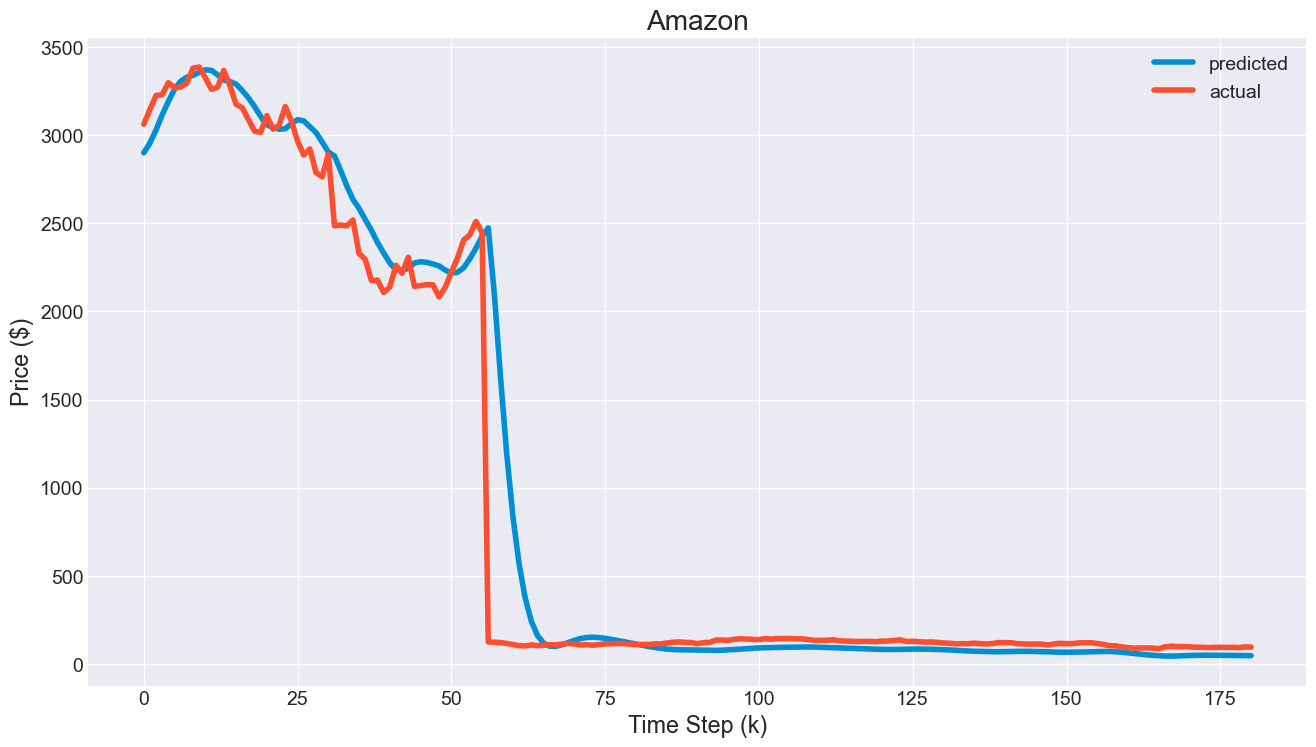

<Figure size 1400x800 with 0 Axes>

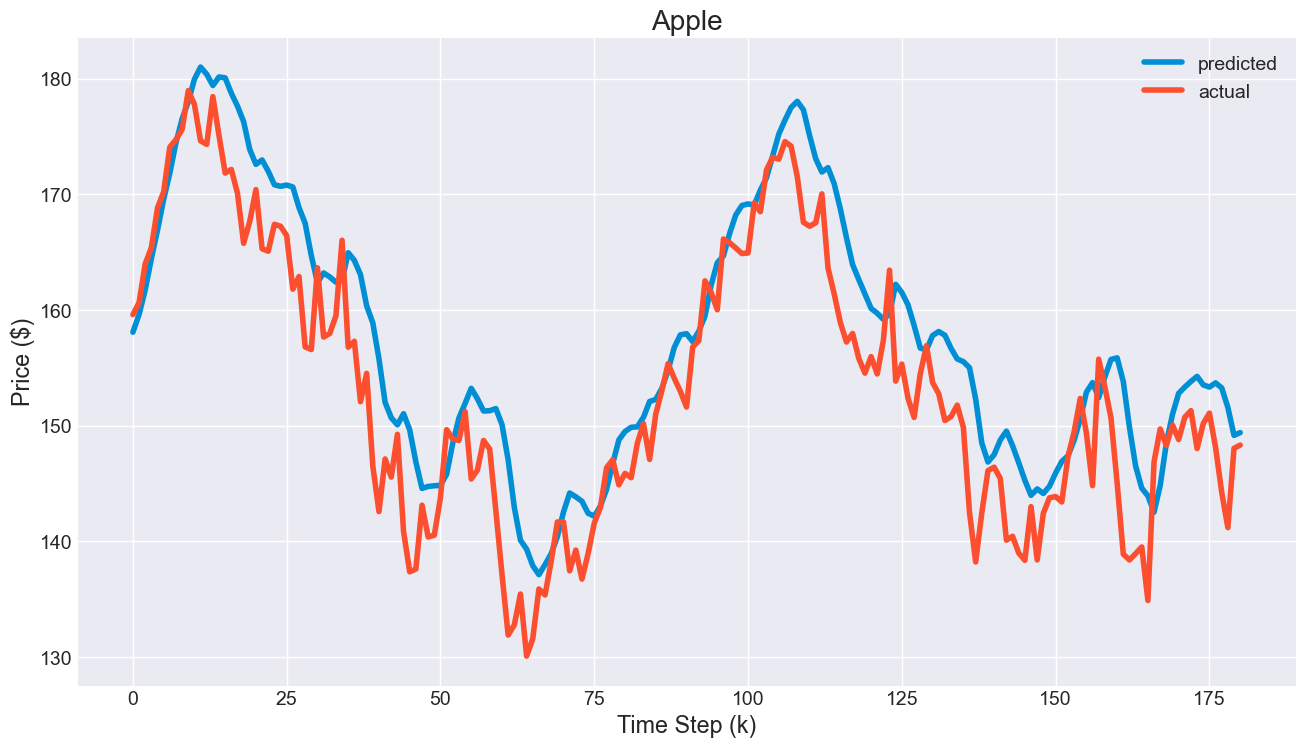

<Figure size 1400x800 with 0 Axes>

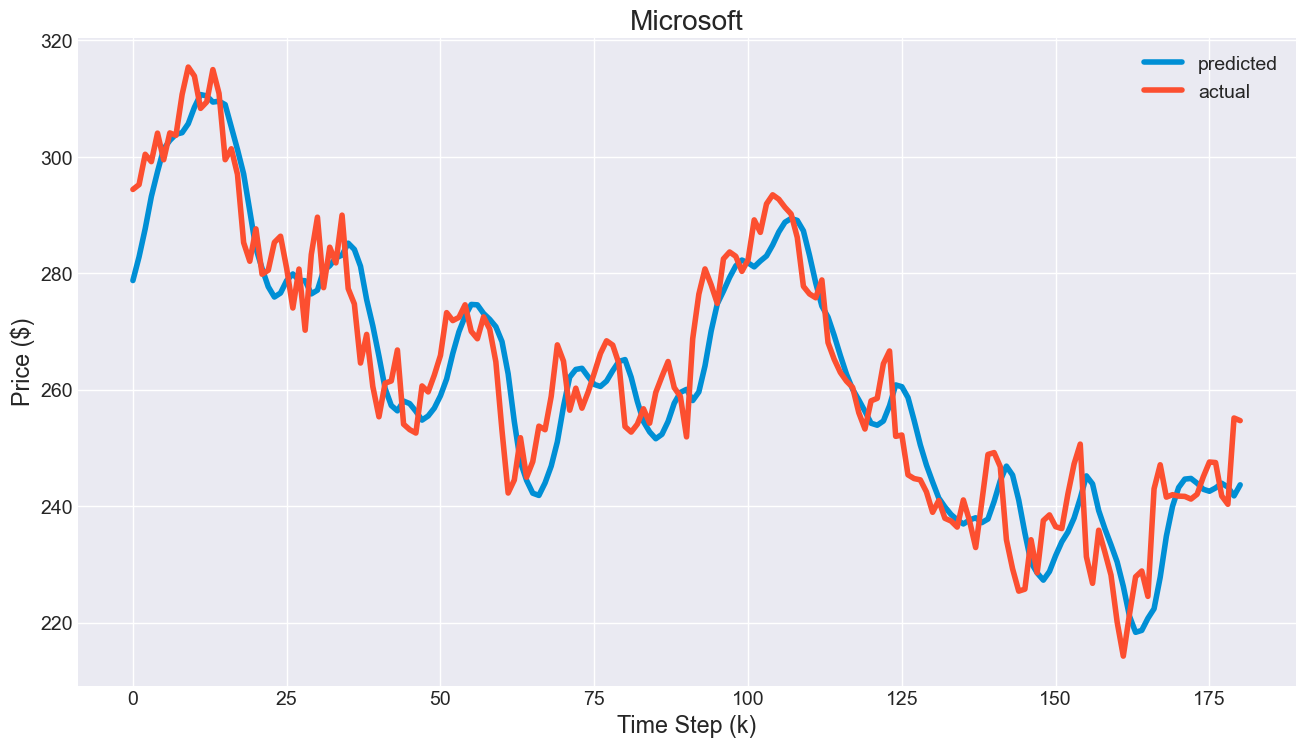

<Figure size 1400x800 with 0 Axes>

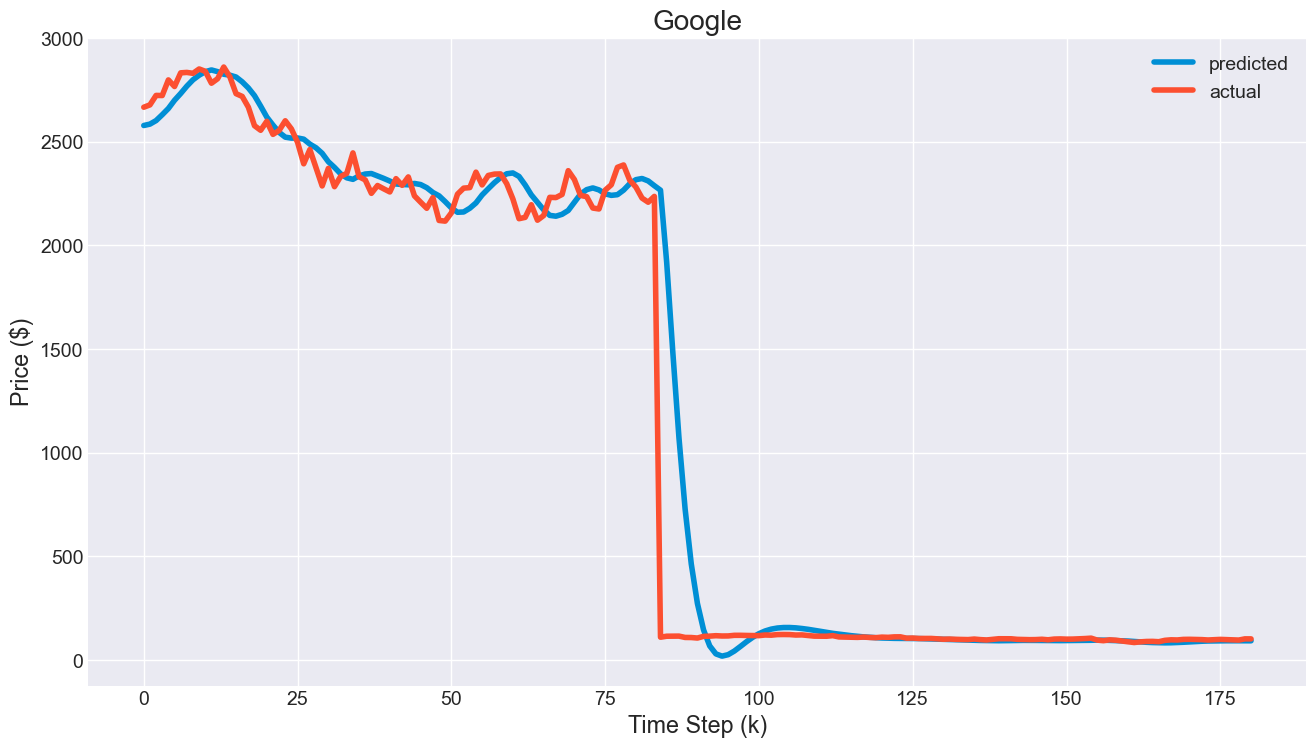

<Figure size 1400x800 with 0 Axes>

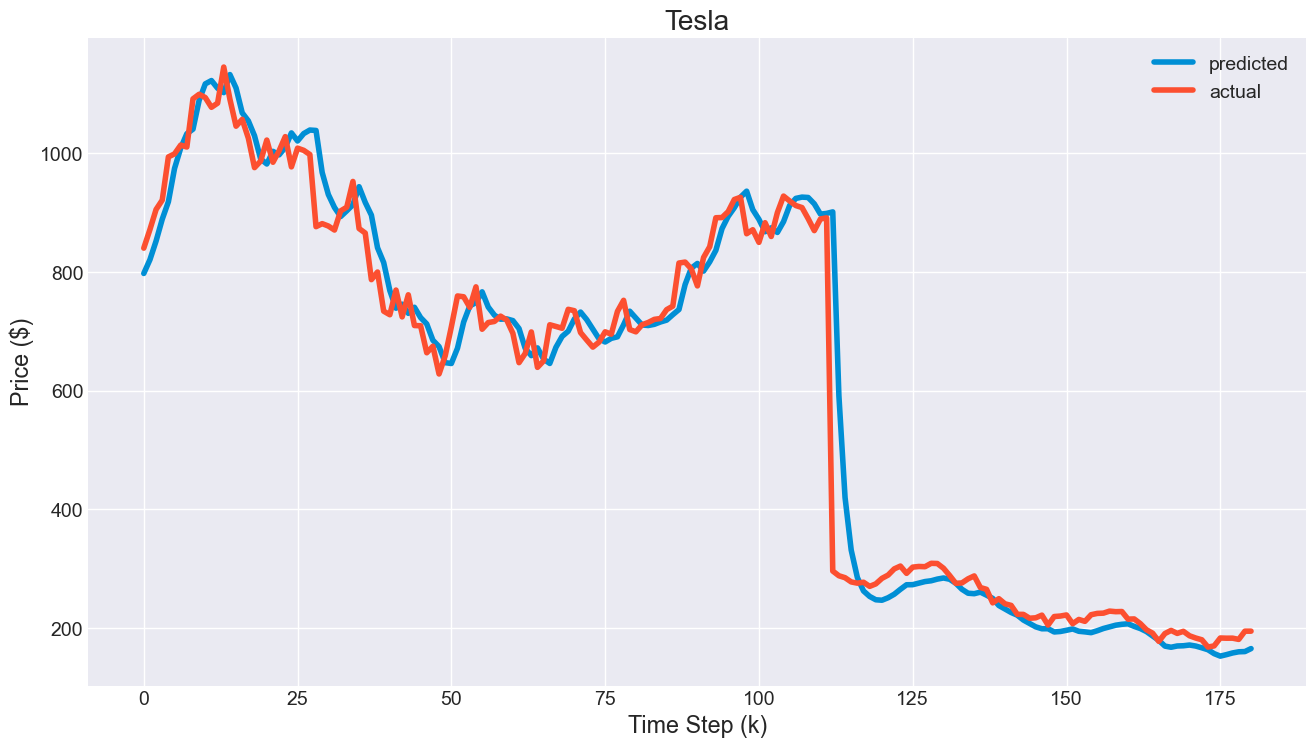

<Figure size 1400x800 with 0 Axes>

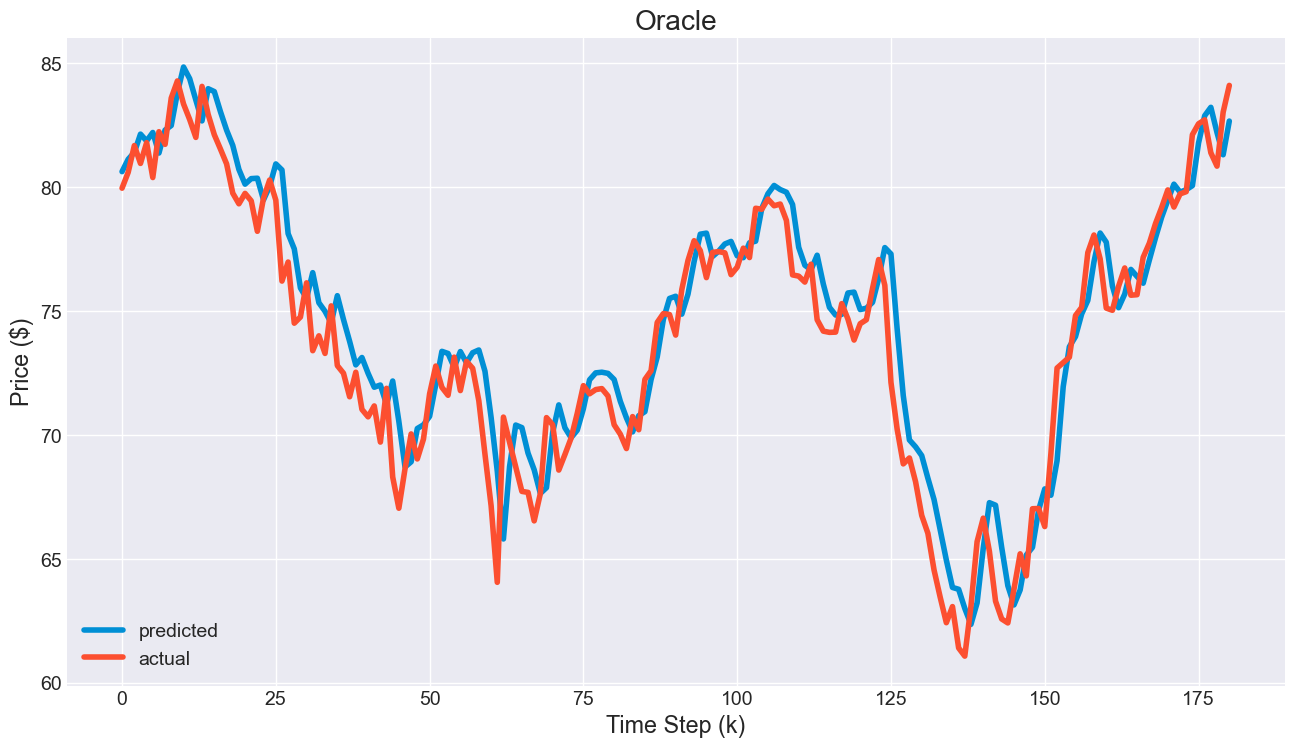

In [5]:
companies_tingo = ['AMZN', 'AAPL', 'MSFT', 'GOOGL', 'TSLA', 'ORCL']
companies_name = ['Amazon', 'Apple', 'Microsoft', 'Google', 'Tesla', 'Oracle']

for idx in range(len(companies_tingo)):
    run_on_lstm_company_stock_price(companies_tingo[idx], companies_name[idx])